In [70]:
import os
from dotenv import load_dotenv
load_dotenv('../.flaskenv')

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from probabilistic.probabilistic_parameters import ProbabilisticParameters
from probabilistic.energy_predictions import EnergyPrediction, ProbabilisticEnergyPrediction
from ml_models import get_scaling_layer

from helper.run_period import get_run_periods

from service import db_functions as db

import matplotlib.pyplot as plt

In [71]:
solid_colors = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
num_solid_colors = len(solid_colors)

def rgb_to_hex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def hex_to_rg(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def get_weighed_color(col1, col2='#ffffff', w=0.5):
    c1 = hex_to_rg(col1)
    c2 = hex_to_rg(col2)
    return rgb_to_hex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min

    def scale(self, value):
        return (value-self.Min)/self.Range
        
    def color(self, value):
        if isinstance(value, np.ndarray):
            vs = []
            for v in value:
                vs.append(get_weighed_color(self.Color1, self.Color2, self.scale(v)))
            return vs
        return get_weighed_color(self.Color1, self.Color2, self.scale(value))
    
trans_colors = [get_weighed_color(x, w=0.2) for x in solid_colors]

In [72]:
user_name = 'tum-gni'
proj_name = 'house-gn'

search_conditions = db.get_search_conditions(user_name, proj_name)

consumption_df = db.get_columns(search_conditions, db.CONSUMPTION, True)
run_periods, targets = get_run_periods(consumption_df)
targets /= 1000

simulation_results = db.get_columns(search_conditions, db.SIMULATION_RESULTS,)
simulation_results = ProbabilisticEnergyPrediction.from_json(simulation_results)
simulation_results = simulation_results.Values['Total']/1000

results = db.get_columns(search_conditions, db.RESULTS,)
predictions = pd.DataFrame.from_dict(results[db.PREDICTIONS])/1000

search_conditions_ed = db.get_search_conditions(user_name, 'house-ed')
results_ed = db.get_columns(search_conditions_ed, db.RESULTS,)
predictions_ed = pd.DataFrame.from_dict(results_ed[db.PREDICTIONS])/1000


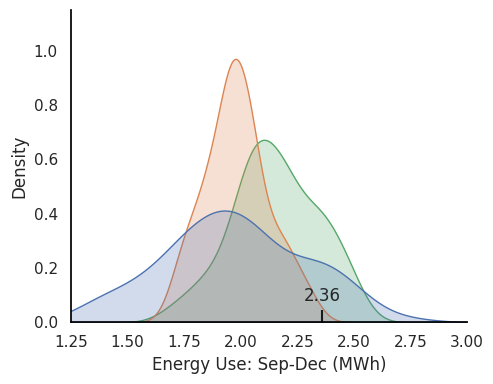

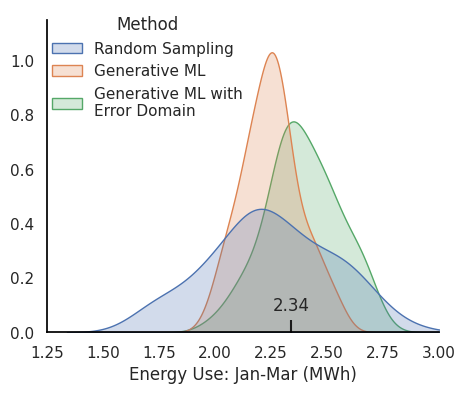

In [84]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set(rc={'figure.figsize':(6,3)})
sns.set_theme(style="whitegrid", 
              rc={
                'axes.edgecolor': 'black',})

# fig, axs = plt.subplots(ncols=2)

for x, month in enumerate(simulation_results):
  d1 = pd.DataFrame()
  d1['Energy'] = simulation_results[month][:100]
  d1['Method'] = 'Random Sampling'
  d1['Month'] = month

  d2 = pd.DataFrame()
  d2['Energy'] = predictions[month][:100]
  d2['Method'] = 'Generative ML'
  d2['Month'] = month

  d3 = pd.DataFrame()
  d3['Energy'] = predictions_ed[month][:100]
  d3['Method'] = 'Generative ML with\nError Domain'
  d3['Month'] = month

  data = pd.concat((d1, d2, d3,))

  apps = np.unique(data['Method'])
  my_pal = dict([(x, y) for x, y in zip(apps, solid_colors[:len(apps)])])

  ax = sns.displot(data, x="Energy", hue="Method", kind="kde", fill=True, multiple='layer', aspect=1.25, height=4)
  # ax = sns.violinplot(data, x='Month', y="Energy", hue="Approach", kind="kde", split=True, fill=False, multiple='stack', aspect=1.5, height=2.5)

  if x==0: ax._legend.remove()
  else: 
    sns.move_legend(ax, "upper right", bbox_to_anchor=(0.41, 1))
    plt.ylabel('')
  
  val = targets['value1'][x]
  plt.scatter(val, 0, 300, marker='|', color='k',)
  plt.text(val, 0.08, f'{val:0.2f}', horizontalalignment='center',)
  plt.grid(False)
  ax.set_xlabels(f'Energy Use: {month} (MWh)')
  plt.ylim(0, 1.15)
  plt.xlim(1.25, 3)
  plt.savefig(f'{user_name}-{proj_name}-{month}-predictions.pdf', bbox_inches='tight')


In [74]:
from scipy.stats import norm
from math import sqrt
from scipy.stats import t

import numpy as np
from numpy.random import seed
from numpy.random import rand
from numpy.random import randint
from numpy import mean
from numpy import median, mean

from numpy import percentile

def ConfidenceIntervalWithoutBS(y):
    y = np.array(y)
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(y, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(y, upper_p)
    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

def ConfidenceInterval(y, n=50):
    
    scores = list()
    dataset = y
    samples = len(dataset)
    for _ in range(n):
        indices = randint(0, samples, samples)
        sample = dataset[indices]
        # calculate and store statistic
        statistic = sqrt(mean(sample))
        scores.append(statistic)
    
    m = mean(scores)
    
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(scores, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(scores, upper_p)

    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

In [85]:
for x, month in enumerate(simulation_results):
  print(month)
  ConfidenceIntervalWithoutBS(predictions[month])
  ConfidenceIntervalWithoutBS(predictions_ed[month])
  ConfidenceIntervalWithoutBS(simulation_results[month])

Sep-Dec
1.73-2.28
1.77-2.48
1.37-2.51
Jan-Mar
2.02-2.52
2.08-2.69
1.73-2.74


In [76]:
predictions

,Sep-Dec,Jan-Mar
0,1.827328,2.129417
1,1.856883,2.151864
2,2.021381,2.296156
3,1.940189,2.214241
4,2.201984,2.457761
...,...,...
95,2.037581,2.301606
96,1.800675,2.095450
97,1.978814,2.248216
98,1.764424,2.065920


In [77]:
penguins = sns.load_dataset("penguins")

In [78]:
np.unique(penguins['species'])

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [79]:
predictions_ed

,Sep-Dec,Jan-Mar
0,2.174102,2.410366
1,2.189710,2.442627
2,2.004835,2.244171
3,2.031568,2.310505
4,2.144812,2.384421
...,...,...
95,2.123980,2.338987
96,2.248798,2.474470
97,2.357673,2.587992
98,2.044249,2.286355
